In [1]:
# Data Analysis Tools
import pandas as pd
import numpy as np

# Machine Learning
from sklearn.cluster import KMeans

# Visualization Method
import plotly.express as px

In [2]:
INPUT_DIR = '../resources/input'
OUTPUT_DIR = '../resources/output'

In [3]:
def read_data(mode: str) -> pd.DataFrame:
    """Read csv data from input dir"""
    global INPUT_DIR
    
    if mode == 'question':
        return pd.read_csv(f"{INPUT_DIR}/questions.csv")
    elif mode == 'lecture':
        return pd.read_csv(f"{INPUT_DIR}/lectures.csv")
    elif mode == 'train':
        return pd.read_csv(f"{INPUT_DIR}/train.csv")
    elif mode == 'sampled_train':
        return pd.read_csv(f"{INPUT_DIR}/sample_train.csv")\
                 .drop(columns = ['Unnamed: 0'])
    elif mode == 'test':
        return pd.read_csv(f"{INPUT_DIR}/test.csv")
    else:
        raise ValueError(f"The mode {mode} is not supported!")
        

In [4]:
# Preprocess Question Data

def preprocess_question_data(question_data: pd.DataFrame) -> pd.DataFrame:
    """Preprocess question data."""
    question_data = _cluster_question_with_tag(question_data)
    question_data = _construct_dummy_data(question_data, 'part')
    
    return question_data

def _parse_tag(question_data):
    question_data['tags_ps'] = question_data['tags'].apply(lambda x: str(x).split(' '))
    
    question_tag_data = question_data.explode('tags_ps')
    question_tag_data = pd.pivot_table(question_tag_data, index = 'question_id', columns = ['tags_ps'], values ='correct_answer', aggfunc = 'count')\
                          .fillna(0)
    
    return question_tag_data

def _cluster_question_with_tag(question_data: pd.DataFrame, cluster_num: int = 7, random_state = 3141592) -> pd.DataFrame:
    """Cluster question data with their own tag information.
    
    In fact, the Elbow method before construct the function indicates that the cluster number is appropriate to set 7 when the random state is 3141592.
    """
    question_tag_data = _parse_tag(question_data)
    cluster = KMeans(cluster_num, random_state = random_state)
    cluster.fit(question_tag_data)
    
    question_data['tag_cluster_label'] = cluster.labels_
    
    return question_data

def _construct_dummy_data(data_frame, column):
    return data_frame.join(
        pd.get_dummies(data_frame[column], prefix = column)
    )

In [5]:
# Preprocess Lecture Data
def preprocess_lecture_data(lecture_data: pd.DataFrame) -> pd.DataFrame:
    """Preprocess lecture data"""
    lecture_data = _construct_dummy_data(lecture_data, 'part')
    
    return lecture_data

In [6]:
def preprocess_log_data(log_data: pd.DataFrame) -> pd.DataFrame:
    """Preprocess log data"""
    # Wrong data correction
    log_data.loc[log_data['timestamp'] == 0, ['prior_question_elapsed_time', 'prior_question_had_explanation']] = np.nan
    
    return log_data

def integrate_data(log_data, question_data, lecture_data):
    integrated_data = pd.merge(log_data, question_data, left_on = 'content_id', right_on = 'question_id', how = 'left')
    integrated_data = pd.merge(integrated_data, lecture_data, left_on = 'content_id', right_on = 'lecture_id', how = 'left', suffixes = ('_question', '_lecture'))
    integrated_data = integrated_data.fillna(0)
    
    user_gp = integrated_data.groupby(['user_id'])

    for content_type in ['lecture']:
        for part in range(1, 8):
            cumul_col = f"part_{part}_{content_type}_cum"
            target_col = f"part_{part}_{content_type}"

            integrated_data[cumul_col] = user_gp[target_col].cumsum()
            
    integrated_data = integrated_data[~integrated_data['content_type_id']]
    
    return integrated_data

In [7]:
log_data = read_data('sampled_train')
question_data = read_data('question')
lecture_data = read_data('lecture')

In [8]:
log_data = preprocess_log_data(log_data)
question_data = preprocess_question_data(question_data)
lecture_data = preprocess_lecture_data(lecture_data)

In [9]:
integrated_data = integrate_data(log_data, question_data, lecture_data)

In [10]:
eigen_integrated_data = integrated_data[['user_id', 'task_container_id', 'prior_question_elapsed_time', 'prior_question_had_explanation', 'answered_correctly', 'part_question', 
                                         'part_1_question', 'part_2_question', 'part_3_question', 'part_4_question', 'part_5_question', 'part_6_question', 'part_7_question']]

eigen_integrated_data['correct_answer_count'] = eigen_integrated_data.groupby(['user_id', 'task_container_id'])['answered_correctly'].transform(func = 'sum')
eigen_integrated_data['total_answer_count'] = eigen_integrated_data.groupby(['user_id', 'task_container_id'])['answered_correctly'].transform(func = 'count')

eigen_integrated_data = eigen_integrated_data.drop_duplicates(['user_id', 'task_container_id'])

eigen_user_gp = eigen_integrated_data.groupby('user_id')

eigen_integrated_data['prior_task_container_id'] = eigen_user_gp['task_container_id'].shift(1)
eigen_integrated_data['correct_answer_count'] = eigen_user_gp['correct_answer_count'].shift(1)
eigen_integrated_data['total_answer_count'] = eigen_user_gp['total_answer_count'].shift(1)

<ipython-input-10-441c5fae71ce>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eigen_integrated_data['correct_answer_count'] = eigen_integrated_data.groupby(['user_id', 'task_container_id'])['answered_correctly'].transform(func = 'sum')
<ipython-input-10-441c5fae71ce>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eigen_integrated_data['total_answer_count'] = eigen_integrated_data.groupby(['user_id', 'task_container_id'])['answered_correctly'].transform(func = 'count')


In [11]:
eigen_integrated_data = eigen_integrated_data[~np.isnan(eigen_integrated_data['prior_task_container_id'])]

eigen_integrated_data = eigen_integrated_data.drop(columns = ['task_container_id'])
eigen_integrated_data = eigen_integrated_data.rename(columns = {e: e[6:] for e in eigen_integrated_data.columns if 'prior' in e})

In [14]:
integrated_data = pd.merge(integrated_data, eigen_integrated_data, on = ['user_id', 'task_container_id'])

In [12]:
for part in range(1, 8):
    target_col = f"part_{part}_question"
    elapsed_time = f"part_{part}_elapsed_time"
    question_saw_explanation = f"part_{part}_had_explanation"
    answer = f"part_{part}_answered"
    correct = f"part_{part}_corrected"
    correct_rate = f"part_{part}_correction_rate"
    
    eigen_integrated_data[elapsed_time] = eigen_integrated_data[target_col] * eigen_integrated_data['question_elapsed_time']
    eigen_integrated_data[question_saw_explanation] = eigen_integrated_data[target_col] * eigen_integrated_data['question_had_explanation'].astype(int)
    eigen_integrated_data[answer] = eigen_integrated_data[target_col] * eigen_integrated_data['total_answer_count']
    eigen_integrated_data[correct] = eigen_integrated_data[target_col] * eigen_integrated_data['correct_answer_count']
    
    eigen_integrated_data[f"{target_col}_cum"] = eigen_integrated_data.groupby('user_id')[target_col].cumsum()
    eigen_integrated_data[f"{elapsed_time}_cum"] = eigen_integrated_data.groupby('user_id')[elapsed_time].cumsum()
    eigen_integrated_data[f"{question_saw_explanation}_cum"] = eigen_integrated_data.groupby('user_id')[question_saw_explanation].cumsum()
    eigen_integrated_data[f"{answer}_cum"] = eigen_integrated_data.groupby('user_id')[answer].cumsum()
    eigen_integrated_data[f"{correct}_cum"] = eigen_integrated_data.groupby('user_id')[correct].cumsum()
    
    eigen_integrated_data[f"{elapsed_time}_mean"] = eigen_integrated_data[f"{elapsed_time}_cum"] / eigen_integrated_data[f"{target_col}_cum"]
    eigen_integrated_data[f"{question_saw_explanation}_mean"] = eigen_integrated_data[f"{question_saw_explanation}_cum"] / eigen_integrated_data[f"{target_col}_cum"]
    eigen_integrated_data[correct_rate] = eigen_integrated_data[f"{correct}_cum"] / eigen_integrated_data[f"{answer}_cum"]
    
eigen_integrated_data = eigen_integrated_data.fillna(0)

In [13]:
ignorable_col = ['answered_correctly', 'part_question', 'part_1_question',
       'part_2_question', 'part_3_question', 'part_4_question',
       'part_5_question', 'part_6_question', 'part_7_question']

eigen_integrated_data = eigen_integrated_data.drop(columns = ignorable_col)

In [16]:
pd.set_option('display.max_column', 1000)
integrated_data['user_id'].nunique()

10040

In [18]:
integrated_data

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,question_id,bundle_id,correct_answer,part_question,tags,tags_ps,tag_cluster_label,part_1_question,part_2_question,part_3_question,part_4_question,part_5_question,part_6_question,part_7_question,lecture_id,tag,part_lecture,type_of,part_1_lecture,part_2_lecture,part_3_lecture,part_4_lecture,part_5_lecture,part_6_lecture,part_7_lecture,part_1_lecture_cum,part_2_lecture_cum,part_3_lecture_cum,part_4_lecture_cum,part_5_lecture_cum,part_6_lecture_cum,part_7_lecture_cum,question_elapsed_time,question_had_explanation,correct_answer_count,total_answer_count,part_1_elapsed_time,part_1_had_explanation,part_1_answered,part_1_corrected,part_1_question_cum,part_1_elapsed_time_cum,part_1_had_explanation_cum,part_1_answered_cum,part_1_corrected_cum,part_1_elapsed_time_mean,part_1_had_explanation_mean,part_1_correction_rate,part_2_elapsed_time,part_2_had_explanation,part_2_answered,part_2_corrected,part_2_question_cum,part_2_elapsed_time_cum,part_2_had_explanation_cum,part_2_answered_cum,part_2_corrected_cum,part_2_elapsed_time_mean,part_2_had_explanation_mean,part_2_correction_rate,part_3_elapsed_time,part_3_had_explanation,part_3_answered,part_3_corrected,part_3_question_cum,part_3_elapsed_time_cum,part_3_had_explanation_cum,part_3_answered_cum,part_3_corrected_cum,part_3_elapsed_time_mean,part_3_had_explanation_mean,part_3_correction_rate,part_4_elapsed_time,part_4_had_explanation,part_4_answered,part_4_corrected,part_4_question_cum,part_4_elapsed_time_cum,part_4_had_explanation_cum,part_4_answered_cum,part_4_corrected_cum,part_4_elapsed_time_mean,part_4_had_explanation_mean,part_4_correction_rate,part_5_elapsed_time,part_5_had_explanation,part_5_answered,part_5_corrected,part_5_question_cum,part_5_elapsed_time_cum,part_5_had_explanation_cum,part_5_answered_cum,part_5_corrected_cum,part_5_elapsed_time_mean,part_5_had_explanation_mean,part_5_correction_rate,part_6_elapsed_time,part_6_had_explanation,part_6_answered,part_6_corrected,part_6_question_cum,part_6_elapsed_time_cum,part_6_had_explanation_cum,part_6_answered_cum,part_6_corrected_cum,part_6_elapsed_time_mean,part_6_had_explanation_mean,part_6_correction_rate,part_7_elapsed_time,part_7_had_explanation,part_7_answered,part_7_corrected,part_7_question_cum,part_7_elapsed_time_cum,part_7_had_explanation_cum,part_7_answered_cum,part_7_corrected_cum,part_7_elapsed_time_mean,part_7_had_explanation_mean,part_7_correction_rate
0,14162,0,140969,7900,False,0,0,1,0.0,0,7900.0,7900.0,0.0,1.0,131 93 81,"[131, 93, 81]",3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23000.0,False,1.0,1.0,23000.0,0.0,1.0,1.0,1.0,23000.0,0.0,1.0,1.0,23000.000000,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,14163,23205,140969,7876,False,1,2,0,23000.0,False,7876.0,7876.0,3.0,1.0,10 94 92,"[10, 94, 92]",4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21000.0,False,0.0,1.0,21000.0,0.0,1.0,0.0,2.0,44000.0,0.0,2.0,1.0,22000.000000,0.000000,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,14164,48652,140969,175,False,2,3,0,21000.0,False,175.0,175.0,2.0,1.0,9 10 92,"[9, 10, 92]",4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

### Cluster Analysis
Elbow method를 통해 `random_state = 3141592`일 때 `n_clusters = 7`로 조정

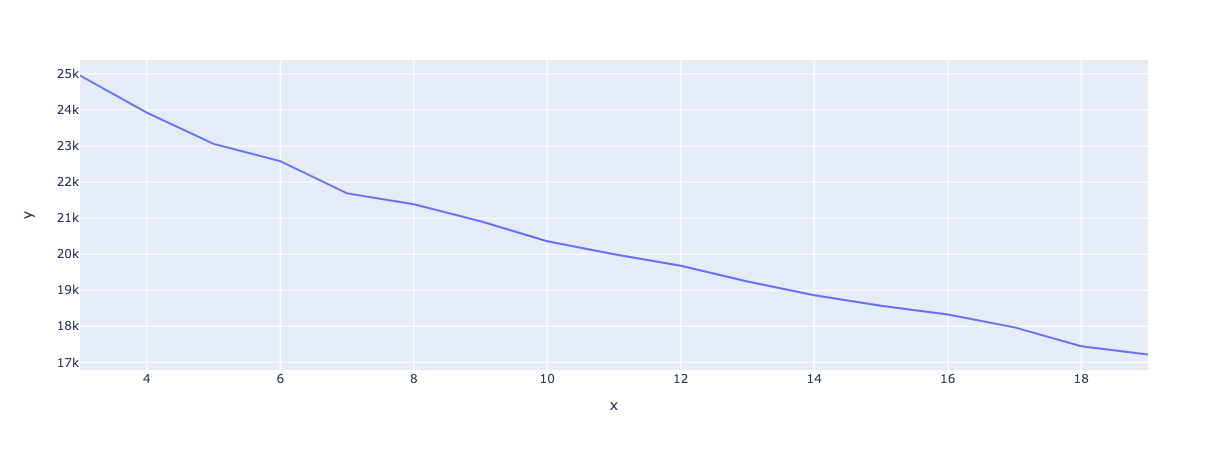

In [28]:
question_tag_data = _parse_tag(question_data)
inertia_list = list()
ran = range(3, 20)
for e in ran:
    kmeans = KMeans(n_clusters = e, random_state = 3141592)
    kmeans.fit(question_tag_data)
    inertia_list.append(kmeans.inertia_)

px.line(y = inertia_list, x = ran)

In [33]:
question_data.groupby(['tag_cluster_label'])[[
                       'part_1', 
                       'part_2', 
                       'part_3', 
                       'part_4', 
                       'part_5', 
                       'part_6', 
                       'part_7']].sum()

,part_1,part_2,part_3,part_4,part_5,part_6,part_7
tag_cluster_label,,,,,,,
0,43.0,0.0,3.0,99.0,4814.0,1158.0,10.0
1,191.0,411.0,387.0,242.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,697.0,54.0,0.0
3,231.0,225.0,276.0,423.0,0.0,0.0,0.0
4,250.0,653.0,734.0,342.0,0.0,0.0,0.0
5,277.0,358.0,162.0,333.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,1150.0
